##  Examples from  Paper

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from torch.distributions.normal import Normal
import torch.optim as optim
import torch.nn as nn
from nde.flows import realnvp
import tqdm
import matplotlib.pyplot as plt
from nde.flows import autoregressive as ar
import utils

torch.set_default_tensor_type(torch.FloatTensor)



# PDF

Survey:   0%|          | 0/200 [00:00<?, ?it/s]

===> tensor(8.3072) 9.16287612915039


Refine:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor(6.6967) 5.569738864898682
tensor(8.1534) 3.9783668518066406
tensor(8.5695) 3.90269136428833
tensor(8.5133) 3.6783103942871094
tensor(8.1539) 3.5313472747802734
tensor(7.7405) 3.2860333919525146
tensor(8.2754) 3.2408018112182617
tensor(8.2885) 3.295149087905884
tensor(8.0769) 3.2971386909484863
tensor(7.9295) 3.1457183361053467
tensor(8.0101) 3.094789743423462
tensor(7.7767) 3.088015556335449
tensor(8.2017) 2.9353840351104736
tensor(7.6207) 2.96474552154541
tensor(7.9699) 3.0626189708709717
tensor(8.0736) 3.015244722366333
tensor(8.1130) 2.873976707458496
tensor(8.3511) 3.0652318000793457
tensor(8.3482) 2.856377124786377
tensor(7.8248) 2.9286279678344727
tensor(7.9518)


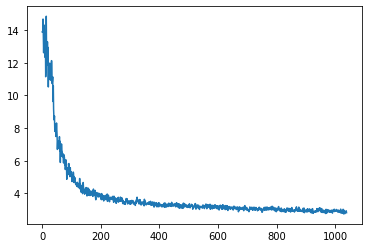

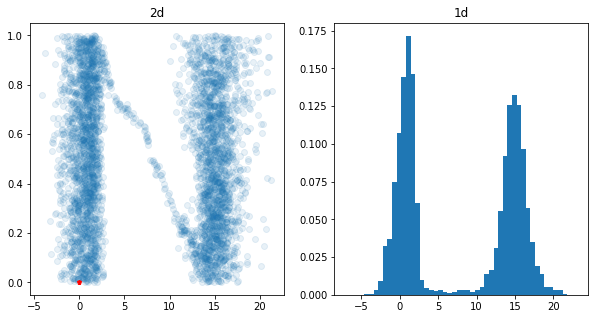

In [2]:
flow = realnvp.SimpleRealNVP(
    features=2,
    hidden_features=20,
    num_layers=15,
    num_blocks_per_layer=2,
)

# flow = ar.MaskedAutoregressiveFlow(
#             features=2,
#             hidden_features=30,
#             num_layers=20,
#             num_blocks_per_layer=2,
#         )


c1 = 1
c2 = 15
centre = (c1 + c2 )/2
xlimits = [-50, 200]
ylimits = [0, 1]
myNorm1 = Normal(torch.tensor([c1]), torch.tensor([0.5]))
myNorm2 = Normal(torch.tensor([c2]), torch.tensor([1.0]))
def f(x):
    return (x[:,1]>0) * (x[:,1]<1) * (myNorm1.log_prob(x[:,0]).exp() * 0.7 + myNorm2.log_prob(x[:,0]).exp() * 0.3)

def survey_sample(n, centre, rho = 1):
    # x = np.random.randn(n) * rho  + centre
    x = np.random.uniform(size=n, low =c1 - 3, high=c2 + 3)
    y = np.random.uniform(size=n, low =0, high=1)
    return torch.FloatTensor(np.concatenate([x.reshape(n, 1), y.reshape(n, 1)], axis=1))

def calLoss(inputs, log_prob):
    return - (f(inputs)  / log_prob.exp() * log_prob).mean()

def filterInputs(inputs):
    return inputs[((inputs[:,0]>xlimits[0]) * (inputs[:,0]<xlimits[1]))
                  * ((inputs[:,1]>ylimits[0]) * (inputs[:,1]<ylimits[1]))]

def plotHistory(history, level=10):
    history = np.array(history)
    idx =  np.where(history > level)[0][-1]
    history =  history[idx+1:]
    plt.plot(history)

optimizer_servy = optim.Adam(flow.parameters(), lr=1e-3)
history = []
for epoch in tqdm.notebook.tqdm(range(200), desc='Survey', leave=False):
    with torch.no_grad():
        inputs = survey_sample(500, 3)
        inputs = filterInputs(inputs)
    log_prob = flow.log_prob(inputs)
    optimizer_servy.zero_grad()
    loss = calLoss(inputs,  log_prob)
    loss.backward()
    optimizer_servy.step()
    history.append(loss.item())

print("===>", inputs[:,0].mean(), loss.item())
optimizer_refine = optim.Adam(flow.parameters(), lr=2e-4)
for epoch in tqdm.notebook.tqdm(range(1000), desc='Refine', leave=False):
    with torch.no_grad():
        inputs = flow.sample(2000).detach()
        inputs = filterInputs(inputs)
        if(epoch % 50 == 49):
            print(inputs[:,0].mean(), loss.item())
    log_prob = flow.log_prob(inputs)
    optimizer_refine.zero_grad()
    loss =  calLoss(inputs,  log_prob)
    loss.backward()
    optimizer_refine.step()
    history.append(loss.item())

plotHistory(history, 15)

import matplotlib.pyplot as plt

with torch.no_grad():
    samples = flow.sample(5000)
    samples = filterInputs(samples)
    s0, s1 = samples[:,0], samples[:,1]
    print(s0.mean())
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.scatter(s0, s1, marker='o', alpha=0.1)
    plt.plot(0, 0, 'rp', markersize=5)

    plt.title("2d")
    plt.subplot(122)
    plt.hist((s0).detach().numpy(), bins=50,  range=(c1-8,  c2+8), density=True) #, range=(0,  200)
    plt.title('1d')
    plt.show()


Survey:   0%|          | 0/100 [00:00<?, ?it/s]

===> tensor(3.5629) 0.8318021297454834


Refine:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor(4.8996) 1.299276351928711
tensor(5.5633) 0.7067320346832275
tensor(6.0907) 0.5678888559341431
tensor(5.7649) 0.5901519060134888
tensor(5.7866) 0.5606598854064941
tensor(5.8476) 0.5380787253379822
tensor(5.6328) 0.5155141949653625
tensor(5.6406) 0.5078709125518799
tensor(5.8023) 0.49740374088287354
tensor(5.7845) 0.5140393376350403
tensor(5.7520) 0.4931859076023102
tensor(6.0215) 0.5108426213264465
tensor(6.0371) 0.4782310128211975
tensor(6.1716) 0.469451904296875
tensor(5.9669) 0.46423545479774475
tensor(6.1111) 0.4486972987651825
tensor(6.2101) 0.4674556851387024
tensor(6.0656) 0.4639010429382324
tensor(6.2746) 0.4461102783679962
tensor(6.2665) 0.45408228039741516
tensor(6.1566)


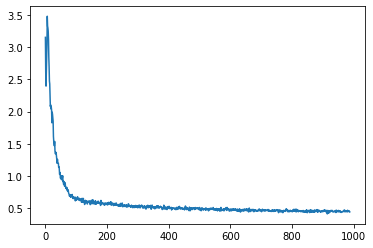

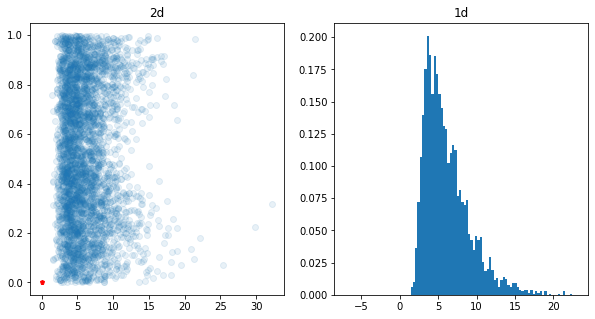

In [3]:
flow = realnvp.SimpleRealNVP(
    features=2,
    hidden_features=20,
    num_layers=10,
    num_blocks_per_layer=2,
)

# flow = ar.MaskedAutoregressiveFlow(
#             features=2,
#             hidden_features=30,
#             num_layers=20,
#             num_blocks_per_layer=2,
#         )

centre = 0.0
level = 3
xlimits = [-50, 200]
ylimits = [0, 1]

myNorm = Normal(torch.tensor([centre]), torch.tensor([3.0]))
def logf(x):
    return myNorm.log_prob(x[:,0]) + torch.log(x[:,0]>level) \
             + torch.log(x[:,1]>0) + torch.log(x[:,1]<1)


def survey_sample(n, centre, rho = 1):
    x = np.random.randn(n) * rho  + centre
    y = np.random.uniform(size=n, low =0, high=1)
    return torch.FloatTensor(np.concatenate([x.reshape(n, 1), y.reshape(n, 1)], axis=1))

def calLoss(inputs, log_prob):
    return - ((logf(inputs) - log_prob).exp() * log_prob).mean()

optimizer_servy = optim.Adam(flow.parameters(), lr=1e-2)
history = []
for epoch in tqdm.notebook.tqdm(range(100), desc='Survey', leave=False):
    with torch.no_grad():
        inputs = survey_sample(300, level + 0.5)
        inputs  = filterInputs(inputs)
    log_prob = flow.log_prob(inputs)
    optimizer_servy.zero_grad()
    loss = calLoss(inputs, log_prob)
    loss.backward()
    optimizer_servy.step()
    history.append(loss.item())

print("===>", inputs[:,0].mean(), loss.item())
optimizer_refine = optim.Adam(flow.parameters(), lr=5e-3)
for epoch in tqdm.notebook.tqdm(range(1000), desc='Refine', leave=False):
    with torch.no_grad():
        inputs = flow.sample(1500).detach()
        inputs  = filterInputs(inputs)
        if(epoch % 50 == 49):
            print(inputs[:,0].mean(), loss.item())
    log_prob = flow.log_prob(inputs)
    optimizer_refine.zero_grad()
    loss = calLoss(inputs, log_prob)
    loss.backward()
    optimizer_refine.step()
    history.append(loss.item())

plotHistory(history, 5)

import matplotlib.pyplot as plt

with torch.no_grad():
    samples = flow.sample(5000)
    samples = filterInputs(samples)
    s0, s1 = samples[:,0], samples[:,1]
    print(s0.mean())
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.scatter(s0, s1, marker='o', alpha=0.1)
    plt.plot(0, 0, 'rp', markersize=5)

    plt.title("2d")
    plt.subplot(122)
    plt.hist((s0).detach().numpy(), bins=100,  range=(level-10,  level+20), density=True) #, range=(0,  200)
    plt.title('1d')
    plt.show()


Survey:   0%|          | 0/200 [00:00<?, ?it/s]

===> tensor(7.4220) 0.0009663593373261392


Refine:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor(6.7118) 0.0030576034914702177
tensor(6.5233) 0.0026877818163484335
tensor(6.4734) 0.0023956503719091415
tensor(6.1349) 0.002572339493781328
tensor(6.4474) 0.002389968605712056
tensor(6.4476) 0.0023053253535181284
tensor(6.5049) 0.00230399495922029
tensor(6.3879) 0.0023631886579096317
tensor(6.3801) 0.002378739882260561
tensor(6.3085) 0.002174883848056197
tensor(6.6199) 0.0021968490909785032
tensor(6.2213) 0.0022255200892686844
tensor(6.4076) 0.0022089662961661816
tensor(6.1940) 0.0022350470535457134
tensor(6.2677) 0.0021258173510432243
tensor(5.8787) 0.0022303240839391947
tensor(6.0261) 0.002213442698121071
tensor(6.0919) 0.0020971933845430613
tensor(5.8097) 0.002101413207128644
tensor(6.1894) 0.0019178682705387473
tensor(5.9652)


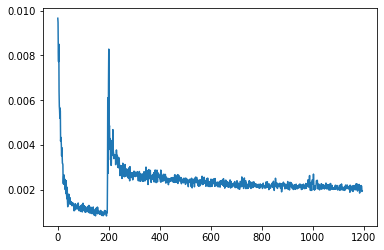

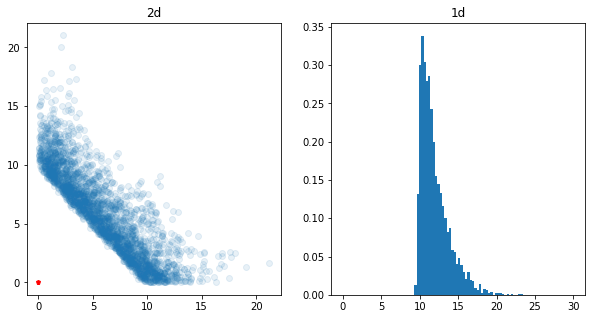

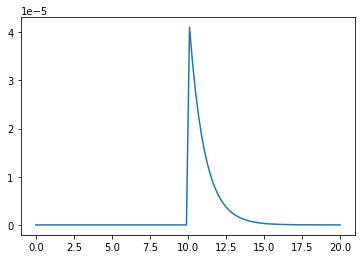

In [4]:
# flow = realnvp.SimpleRealNVP(
#     features=2,
#     hidden_features=20,
#     num_layers=10,
#     num_blocks_per_layer=2,
# )

flow = ar.MaskedAutoregressiveFlow(
            features=2,
            hidden_features=30,
            num_layers=20,
            num_blocks_per_layer=2,
        )

centre = 0
level = 10
centre_servey =  level + 0.2

xlimits = [0, 30]
ylimits = [0, 30]

def f(x):
    return torch.FloatTensor(np.exp(-x[:, 0] -x[:, 1])) * (x[:,0] + x[:,1] > level) * (x[:,0]>0)* (x[:,1]>0)

def logf(x):
      return -x[:, 0] -x[:, 1] + torch.log(x[:,0] + x[:,1] > level) \
             + torch.log(x[:,0]>0) + torch.log(x[:,1]>0)

def calLoss(inputs, log_prob):
    return - ((logf(inputs) - log_prob).exp() * log_prob).mean()

def survey_sample(n, centre, rho = 1):
    x = np.random.uniform(size=n, low =0, high=level*1.5)
    y = np.random.uniform(size=n, low =0, high=level*1.5)
    return torch.FloatTensor(np.concatenate([x.reshape(n, 1), y.reshape(n, 1)], axis=1))

optimizer_servy = optim.Adam(flow.parameters(), lr=1e-3)
history = []
for epoch in tqdm.notebook.tqdm(range(200), desc='Survey', leave=False):
    with torch.no_grad():
        inputs = survey_sample(1000, centre_servey)
        inputs =  filterInputs(inputs)
    log_prob = flow.log_prob(inputs)
    optimizer_servy.zero_grad()
    loss = calLoss(inputs, log_prob)
    # loss = - (f(inputs) * log_prob / log_prob.exp() ).mean() #  (log_prob/logf(inputs) ).mean()
    loss.backward()
    optimizer_servy.step()
    history.append(loss.item())

print("===>", inputs[:,0].mean(), loss.item())
optimizer_refine = optim.Adam(flow.parameters(), lr=1e-3)
for epoch in tqdm.notebook.tqdm(range(1000), desc='Refine', leave=False):
    with torch.no_grad():
        inputs = flow.sample(800).detach()
        inputs =  filterInputs(inputs)
        if(epoch % 50 == 49):
            print(inputs[:,0].mean(), loss.item())
    log_prob = flow.log_prob(inputs)
    optimizer_refine.zero_grad()
    loss = calLoss(inputs, log_prob)
    loss.backward()
    optimizer_refine.step()
    history.append(loss.item())

plotHistory(history, 0.01)

import matplotlib.pyplot as plt

with torch.no_grad():
    samples = flow.sample(3000)
    samples = filterInputs(samples)
    s0, s1 = samples[:,0], samples[:,1]
    print(s0.mean())
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.scatter(s0, s1, marker='o', alpha=0.1)
    plt.plot(0, 0, 'rp', markersize=5)

    plt.title("2d")
    plt.subplot(122)
    plt.hist((s0+s1).detach().numpy(), bins=100,  range=(level-10,  level+20), density=True) #, range=(0,  200)
    plt.title('1d')
    plt.show()

    def myexp(x):
        return np.exp(-x) *  (x>10)
    x = np.linspace(0,20,100)
    plt.plot(x,  myexp(x))

tensor(5.9640)


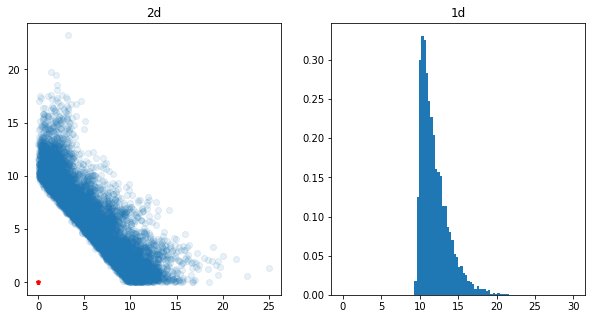

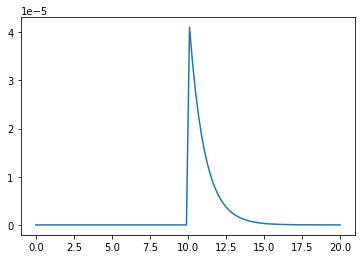

In [5]:
with torch.no_grad():
    samples = flow.sample(10000)
    samples = filterInputs(samples)
    s0, s1 = samples[:,0], samples[:,1]
    print(s0.mean())
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.scatter(s0, s1, marker='o', alpha=0.1)
    plt.plot(0, 0, 'rp', markersize=5)

    plt.title("2d")
    plt.subplot(122)
    plt.hist((s0+s1).detach().numpy(), bins=100,  range=(level-10,  level+20), density=True) #, range=(0,  200)
    plt.title('1d')
    plt.show()

    def myexp(x):
        return np.exp(-x) *  (x>10)
    x = np.linspace(0,20,100)
    plt.plot(x,  myexp(x))